## COVID19 CT Pneumonia Detection - Multiclass Case
By Adrian Yijie Xu
(https://medium.com/@adrianitsaxu)

As discussed in "Detecting COVID-19 induced Pneumonia from Chest X-rays with Transfer Learning: An implementation in Tensorflow and Keras."
(https://github.com/EXJUSTICE/GradientCrescent)

50% test accuracy with 4 classes
100% test accuracy with 3 classes

Conclusion: Viral Pneumonia indistinguishable from COVID19: acceptable, given that COVID19 is itself caused by viral means.



In [21]:
from google.colab import drive
drive.mount('/content/drive')

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#set randomness for reproducibility
import os
from numpy.random import seed
seed(8) #1
#from tensorflow import set_random_seed
import tensorflow as tf
tf.random.set_seed(7) #2

#

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


basePath = "/content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/"
covDataPath = basePath+'Covid_Data_GradientCrescent'
#!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
#!unzip Covid_Data_GradientCrescent.zip
#!unzip covDataPath
print(basePath)
print(covDataPath)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/
/content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/Covid_Data_GradientCrescent


In [22]:
print(os.listdir(basePath))
print(os.listdir(covDataPath))
#Print and remove zips once done

#!rm Covid_Data_GradientCrescent.zip



['Covid19_GradientCrescent_Multi.ipynb', 'covid_3class.png', 'covid_4class.png', 'README.md', 'covid_binary.png', 'Covid19_GradientCrescent_Binary.ipynb', 'covidcomparison.png', '.git', 'Covid_Data_GradientCrescent']
['all', 'two']


In [23]:
#Enable this cell to remove viral pneumonia class. Remember to Change model's final layer to 3 neurons.
!rm -rf /content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/Covid_Data_GradientCrescent/all/test/pneumonia_vir

!rm -rf /content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/Covid_Data_GradientCrescent/all/train/pneumonia_vir

In [24]:
from os import listdir
data_list = listdir(covDataPath+'/all/train')

#Delete some classes that may interfere


data_list

['normal', 'covid', 'pneumonia_bac', 'pneumonia_vir']

Case 2: COVID vs Normal vs Tertiary Pneumonia (Bacterial and Viral)
VGG Initialization

In [25]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf


DATASET_PATH  = covDataPath+'/all/train'
test_dir =  covDataPath+'/all/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE =0.0001



#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"
                                                 
                                                  )



/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1290: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


Layer Modification at upper layer of VGG16

In [29]:
#Simple CNN model based on VGG16. Set dense layer neuron count to 3 if viral pneumonia class is removed


from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.trainable = False


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

In [30]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 16,813,124
Trainable params: 2,098,436
Non-trainable params: 14,714,688
_________________________________________________________________
None


Training

In [31]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,                        
                       )



22
6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/100
21/21 [==============================] - 196s 9s/step - loss: 1.4295 - acc: 0.3350 - val_loss: 1.2116 - val_acc: 0.5200
Epoch 2/100
21/21 [==============================] - 6s 283ms/step - loss: 1.2191 - acc: 0.4709 - val_loss: 1.3752 - val_acc: 0.4400
Epoch 3/100
21/21 [==============================] - 6s 282ms/step - loss: 1.1270 - acc: 0.4903 - val_loss: 1.1028 - val_acc: 0.5400
Epoch 4/100
21/21 [==============================] - 6s 283ms/step - loss: 0.9956 - acc: 0.5825 - val_loss: 1.0089 - val_acc: 0.5400
Epoch 5/100
21/21 [==============================] - 6s 289ms/step - loss: 0.9865 - acc: 0.5874 - val_loss: 1.1097 - val_acc: 0.4600
Epoch 6/100
21/21 [==============================] - 6s 287ms/step - loss: 0.9309 - acc: 0.6019 - val_loss: 1.1410 - val_acc: 0.4000
Epoch 7/100
21/21 [==============================] - 6s 283ms/step - loss: 0.9621 - acc: 0.6359 - val_loss: 0.8972 - val_acc: 0.6000
Epoch 8/100
21/21 [==============================] - 6s 280ms/step - l

Evaluation

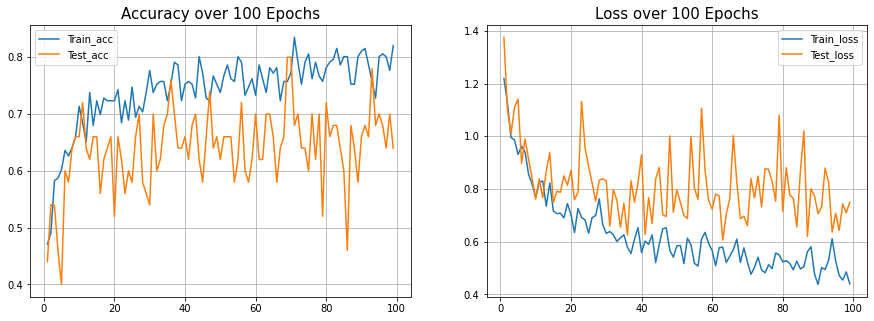

In [32]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 100)

In [33]:
model.save('Covid_Multi.h5')

Predict

In [34]:

#Dont forget shuffle false
#See https://github.com/keras-team/keras/issues/6499
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=True,
        seed=42,
        
        class_mode="categorical")
eval_generator.reset()    


Found 36 images belonging to 4 classes.


In [35]:

eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

#Poor test accuracy due to the small dataset size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


4/4 [==============================] - 3s 667ms/step - loss: 2.4180 - acc: 0.5000
Test loss: 2.4180142879486084
Test accuracy: 0.5


Optional: Finetuning with a learning rate of 5E-5

In [36]:

model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=5e-5),
              metrics=['acc'])

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= 20,                        
                       )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
21/21 [==============================] - 7s 308ms/step - loss: 0.4893 - acc: 0.8204 - val_loss: 0.7417 - val_acc: 0.5800
Epoch 2/20
21/21 [==============================] - 6s 281ms/step - loss: 0.5076 - acc: 0.7913 - val_loss: 0.6538 - val_acc: 0.6400
Epoch 3/20
21/21 [==============================] - 6s 284ms/step - loss: 0.4530 - acc: 0.8204 - val_loss: 0.8631 - val_acc: 0.6600
Epoch 4/20
21/21 [==============================] - 6s 287ms/step - loss: 0.4609 - acc: 0.8301 - val_loss: 0.7725 - val_acc: 0.6200
Epoch 5/20
21/21 [==============================] - 6s 289ms/step - loss: 0.5337 - acc: 0.7670 - val_loss: 0.9598 - val_acc: 0.6600
Epoch 6/20
21/21 [==============================] - 6s 283ms/step - loss: 0.4464 - acc: 0.8048 - val_loss: 0.6272 - val_acc: 0.7200
Epoch 7/20
21/21 [==============================] - 6s 287ms/step - loss: 0.4351 - acc: 0.8301 - val_loss: 0.6487 - val_acc: 0.7000
Epoch 8/20
21/21 [==============================] - 8s 381ms/step - loss: 0.

In [ ]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])


3/3 [==============================] - 0s 36ms/step
Test loss: 0.021353596743817132
Test accuracy: 1.0


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
